In [1]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "reshape2", "grid", "ggpubr", "patchwork", "cowplot")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)

df <- ndjson::stream_in("./self_ensemble.jsonl")
# print(names(df))

df <- df %>%
    filter(dataset == "cifar10") # cifar10, cifar100, imagenette


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:ggpubr’:

    get_legend




# fgsm vs. pgd

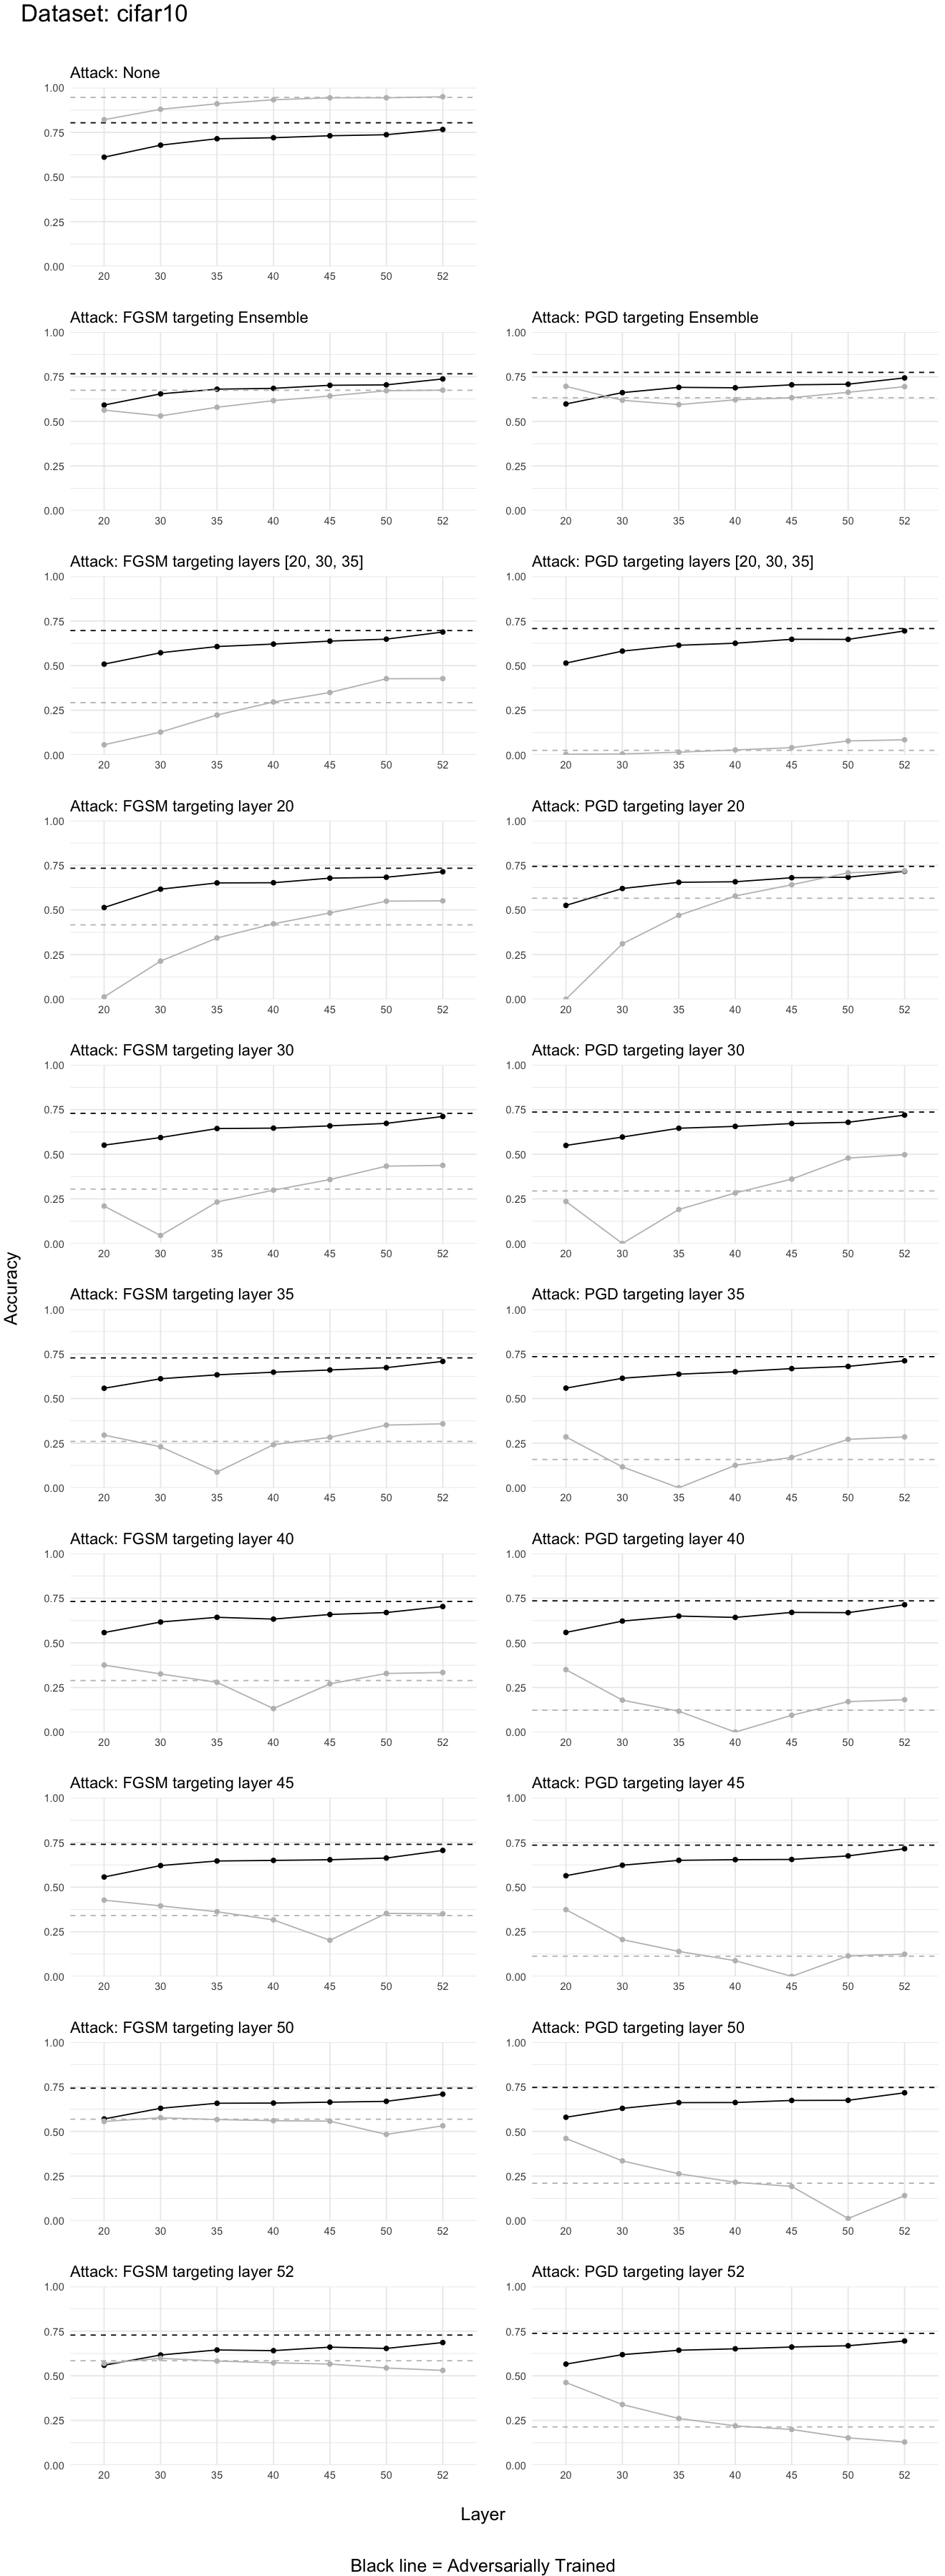

In [2]:
options(repr.plot.width=11, repr.plot.height=30)

get_plot <- function(description, acc_cols, acc_ensemble) {
    p <- ggplot() +
        # adv training
        geom_line(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "black") +
        geom_point(data = melt(df[df$training_natural == TRUE], measure.vars = acc_cols), aes(x = variable, y = value), color = "black") +
        geom_hline(yintercept = df[[acc_ensemble]][2], color = "black", linetype = "dashed", linewidth = 0.5) +
        # no adv training
        geom_line(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value, group = 1), color = "gray") +
        geom_point(data = melt(df[df$training_natural == FALSE], measure.vars = acc_cols), aes(x = variable, y = value), color = "gray") +    
        geom_hline(yintercept = df[[acc_ensemble]][1], color = "gray", linetype = "dashed", linewidth = 0.5) +
        ggtitle(description) +
        xlab("") +
        ylab("") +
        theme_minimal() +
        scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) + # limit y range
        scale_x_discrete(labels = function(x) sub(".*\\.", "", x)) # show only layer number on x-axis
    
    return(p)
}

plot_list <- list()

description <- "Attack: None"
acc_cols <- c("plain_layer_accs.20", "plain_layer_accs.30", "plain_layer_accs.35", "plain_layer_accs.40", "plain_layer_accs.45", "plain_layer_accs.50", "plain_layer_accs.52")
acc_ensemble <- "plain_ensemble_acc"
p1 <- get_plot(description, acc_cols, acc_ensemble)

plot_list[[1]] <- p1
plot_list[[2]] <- ggplot() + theme_void()

description <- "Attack: FGSM targeting Ensemble"
acc_cols <- c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52")
acc_ensemble <- "fgsmensemble_ensemble_acc"
p1 <- get_plot(description, acc_cols, acc_ensemble)

description <- "Attack: PGD targeting Ensemble"
acc_cols <- c("pgdensemble_layer_accs.20", "pgdensemble_layer_accs.30", "pgdensemble_layer_accs.35", "pgdensemble_layer_accs.40", "pgdensemble_layer_accs.45", "pgdensemble_layer_accs.50", "pgdensemble_layer_accs.52")
acc_ensemble <- "pgdensemble_ensemble_acc"
p2 <- get_plot(description, acc_cols, acc_ensemble)

plot_list[[3]] <- p1
plot_list[[4]] <- p2

description <- "Attack: FGSM targeting layers [20, 30, 35]"
acc_cols <- c("fgsmcombined_[20, 30, 35]_layer_accs.20", "fgsmcombined_[20, 30, 35]_layer_accs.30", "fgsmcombined_[20, 30, 35]_layer_accs.35", "fgsmcombined_[20, 30, 35]_layer_accs.40", "fgsmcombined_[20, 30, 35]_layer_accs.45", "fgsmcombined_[20, 30, 35]_layer_accs.50", "fgsmcombined_[20, 30, 35]_layer_accs.52")
acc_ensemble <- "fgsmcombined_[20, 30, 35]_ensemble_acc"
p1 <- get_plot(description, acc_cols, acc_ensemble)

description <- "Attack: PGD targeting layers [20, 30, 35]"
acc_cols <- c("pgdcombined_[20, 30, 35]_layer_accs.20", "pgdcombined_[20, 30, 35]_layer_accs.30", "pgdcombined_[20, 30, 35]_layer_accs.35", "pgdcombined_[20, 30, 35]_layer_accs.40", "pgdcombined_[20, 30, 35]_layer_accs.45", "pgdcombined_[20, 30, 35]_layer_accs.50", "pgdcombined_[20, 30, 35]_layer_accs.52")
acc_ensemble <- "pgdcombined_[20, 30, 35]_ensemble_acc"
p2 <- get_plot(description, acc_cols, acc_ensemble)

plot_list[[5]] <- p1
plot_list[[6]] <- p2

layers <- c(20, 30, 35, 40, 45, 50, 52)
for (layer in layers) {
    description <- paste("Attack: FGSM targeting layer", layer)
    acc_cols <- c(paste("fgsm_", layer, "_layer_accs.20", sep=""), paste("fgsm_", layer, "_layer_accs.30", sep=""), paste("fgsm_", layer, "_layer_accs.35", sep=""), paste("fgsm_", layer, "_layer_accs.40", sep=""), paste("fgsm_", layer, "_layer_accs.45", sep=""), paste("fgsm_", layer, "_layer_accs.50", sep=""), paste("fgsm_", layer, "_layer_accs.52", sep=""))
    acc_ensemble <- paste("fgsm_", layer, "_ensemble_acc", sep="")
    p1 <- get_plot(description, acc_cols, acc_ensemble)
    
    description <- paste("Attack: PGD targeting layer", layer)
    acc_cols <- c(paste("pgd_", layer, "_layer_accs.20", sep=""), paste("pgd_", layer, "_layer_accs.30", sep=""), paste("pgd_", layer, "_layer_accs.35", sep=""), paste("pgd_", layer, "_layer_accs.40", sep=""), paste("pgd_", layer, "_layer_accs.45", sep=""), paste("pgd_", layer, "_layer_accs.50", sep=""), paste("pgd_", layer, "_layer_accs.52", sep=""))
    acc_ensemble <- paste("pgd_", layer, "_ensemble_acc", sep="")
    p2 <- get_plot(description, acc_cols, acc_ensemble)

    plot_list[[length(plot_list) + 1]] <- p1
    plot_list[[length(plot_list) + 1]] <- p2
}

ds <- df$dataset[1]
combined <- grid.arrange(
    grobs = plot_list, 
    ncol = 2,
    top = textGrob(paste("Dataset:", ds, "\n"), gp = gpar(fontsize = 20), hjust = 0, x = unit(0, "npc")),
    bottom = textGrob("Layer\n\nBlack line = Adversarially Trained", gp = gpar(fontsize = 15)),
    left = textGrob("Accuracy", gp = gpar(fontsize = 15), rot = 90)
)

# masks

`summarise()` has grouped output by 'mask_per_rowcol'. You can override using
the `.groups` argument.


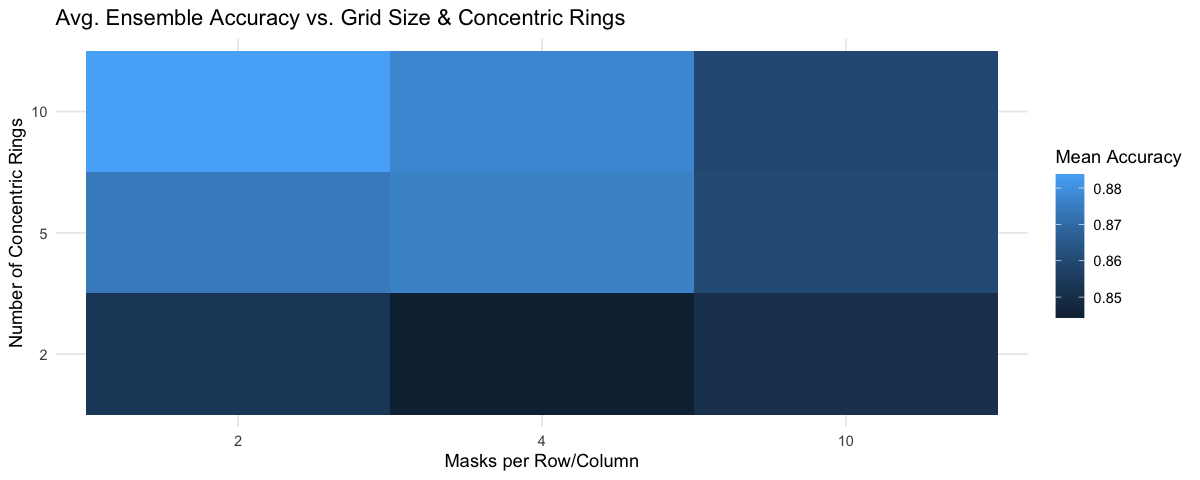

`geom_smooth()` using formula = 'y ~ x'


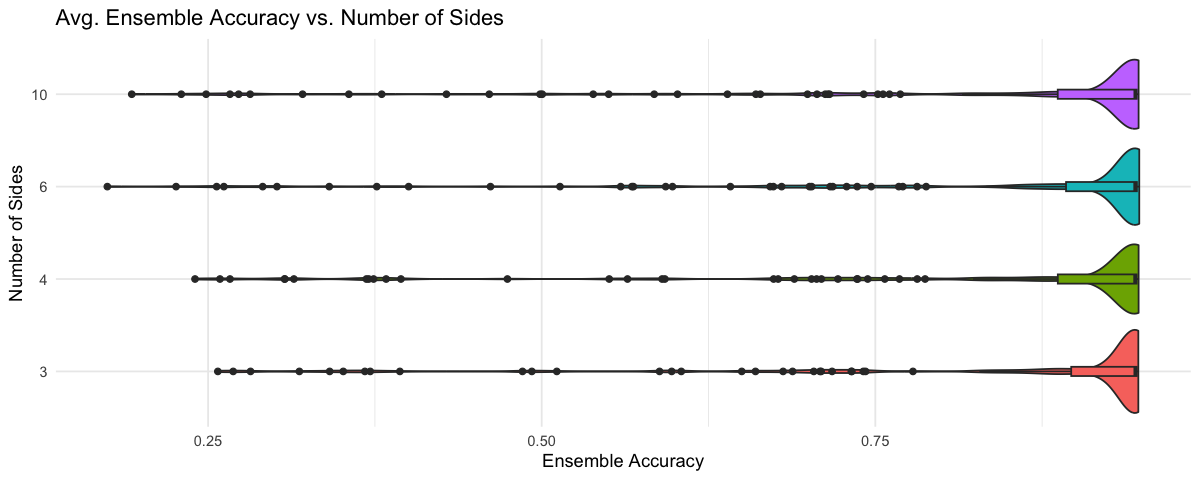

`geom_smooth()` using formula = 'y ~ x'


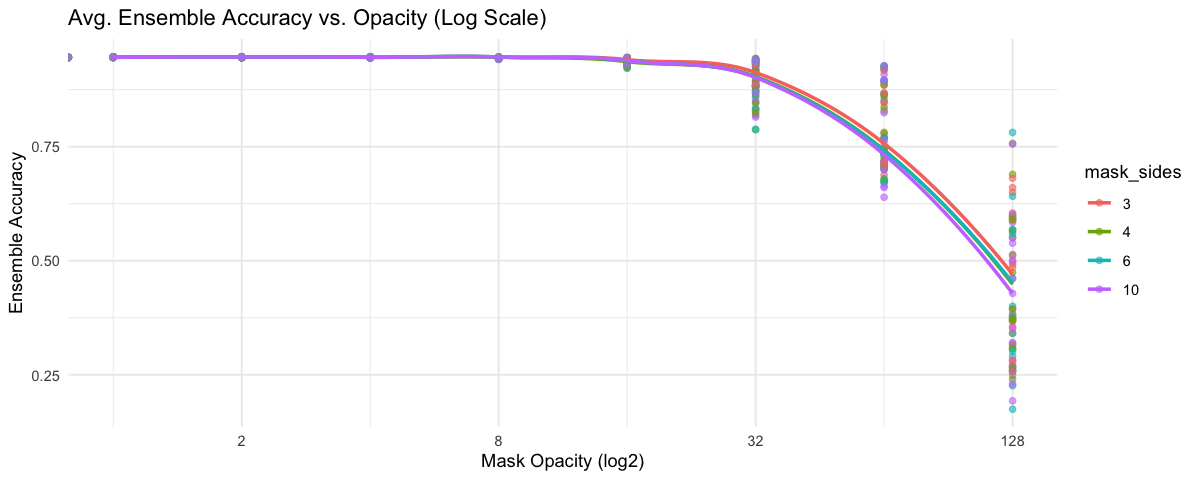

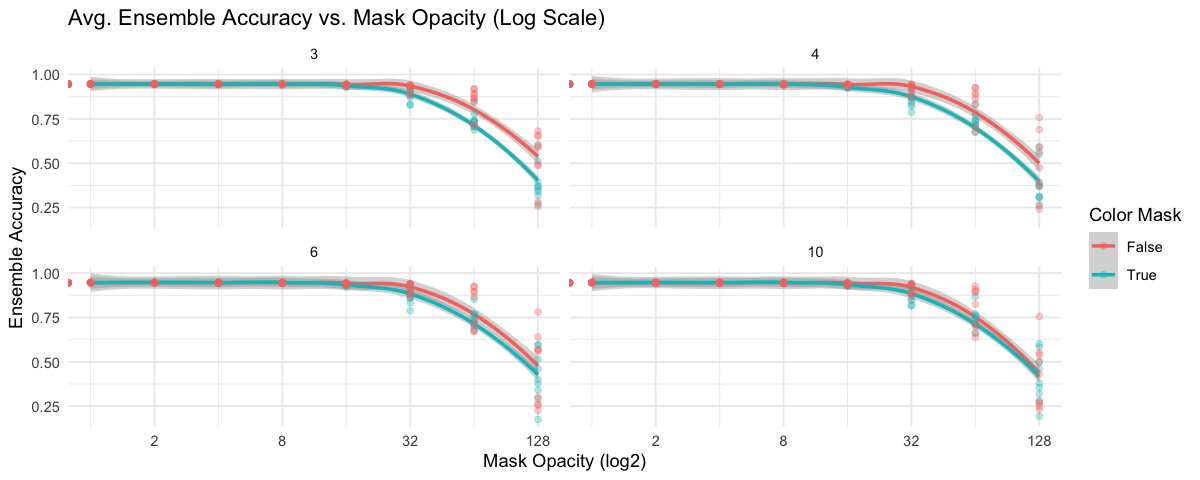

In [3]:
options(repr.plot.width=10, repr.plot.height=4)
options(warn=-1)

mask_opacities <- c(0, 1, 2, 4, 8, 16, 32, 64, 128)
mask_sides <- c(3, 4, 6, 10)
mask_per_rowcols <- c(2, 4, 10)
mask_num_concentrics <- c(2, 5, 10)
mask_colors <- c(TRUE, FALSE)

combinations <- expand.grid(mask_opacities, mask_sides, mask_per_rowcols, mask_num_concentrics, mask_colors)

df_plot <- data.frame(
    mask_opacity = combinations[,1],
    mask_sides = as.factor(combinations[,2]),
    mask_per_rowcol = as.factor(combinations[,3]),
    mask_num_concentric = as.factor(combinations[,4]),
    mask_color = ifelse(combinations[,5], "True", "False"),
    ensemble_acc = sapply(1:nrow(combinations), function(i) {
        mask_opacity <- combinations[i, 1]
        mask_side <- combinations[i, 2]
        mask_per_rowcol <- combinations[i, 3]
        mask_num_concentric <- combinations[i, 4]
        mask_color <- ifelse(combinations[i, 5], "True", "False")        
        mask_name <- paste("mask", mask_opacity, mask_side, mask_per_rowcol, mask_num_concentric, mask_color, sep="_")
        return(max(df[[paste(mask_name, "_ensemble_acc", sep="")]])) # get larger ensemble acc
    })
)

# cifar10: 2 rings, 4 per rowcol is the best
df_plot %>%
    group_by(mask_per_rowcol, mask_num_concentric) %>%
    summarize(mean_acc = mean(ensemble_acc)) %>%
    ggplot(aes(x = mask_per_rowcol, y = mask_num_concentric, fill = mean_acc)) +
    geom_tile() +
    theme_minimal() +
    labs(title = "Avg. Ensemble Accuracy vs. Grid Size & Concentric Rings",
        x = "Masks per Row/Column",
        y = "Number of Concentric Rings",
        fill = "Mean Accuracy")

# cifar10: side number doesn't matter
ggplot(df_plot, aes(x=ensemble_acc, y=mask_sides, fill=mask_sides)) +
    geom_violin() +
    geom_boxplot(width=0.1) +
    theme_minimal() +
    labs(title="Avg. Ensemble Accuracy vs. Number of Sides",
        x="Ensemble Accuracy",
        y="Number of Sides") +
    theme(legend.position="none")

# cifar10: opacity stars working from 32
ggplot(df_plot, aes(x=mask_opacity, y=ensemble_acc, color=mask_sides)) +
    geom_point(alpha=0.6) +
    geom_smooth(method="loess", se=FALSE) +
    scale_x_continuous(trans='log2') +
    theme_minimal() +
    labs(title="Avg. Ensemble Accuracy vs. Opacity (Log Scale)",
        x="Mask Opacity (log2)",
        y="Ensemble Accuracy")

# cifar10: color=true is a lot better
ggplot(df_plot, aes(x = mask_opacity, y = ensemble_acc, color = mask_color)) +
    geom_smooth(method = "loess") +
    geom_point(alpha = 0.3) +
    facet_wrap(~mask_sides) +
    scale_x_continuous(trans='log2') +
    theme_minimal() +
    labs(title = "Avg. Ensemble Accuracy vs. Mask Opacity (Log Scale)",
             x = "Mask Opacity (log2)",
             y = "Ensemble Accuracy",
             color = "Color Mask")


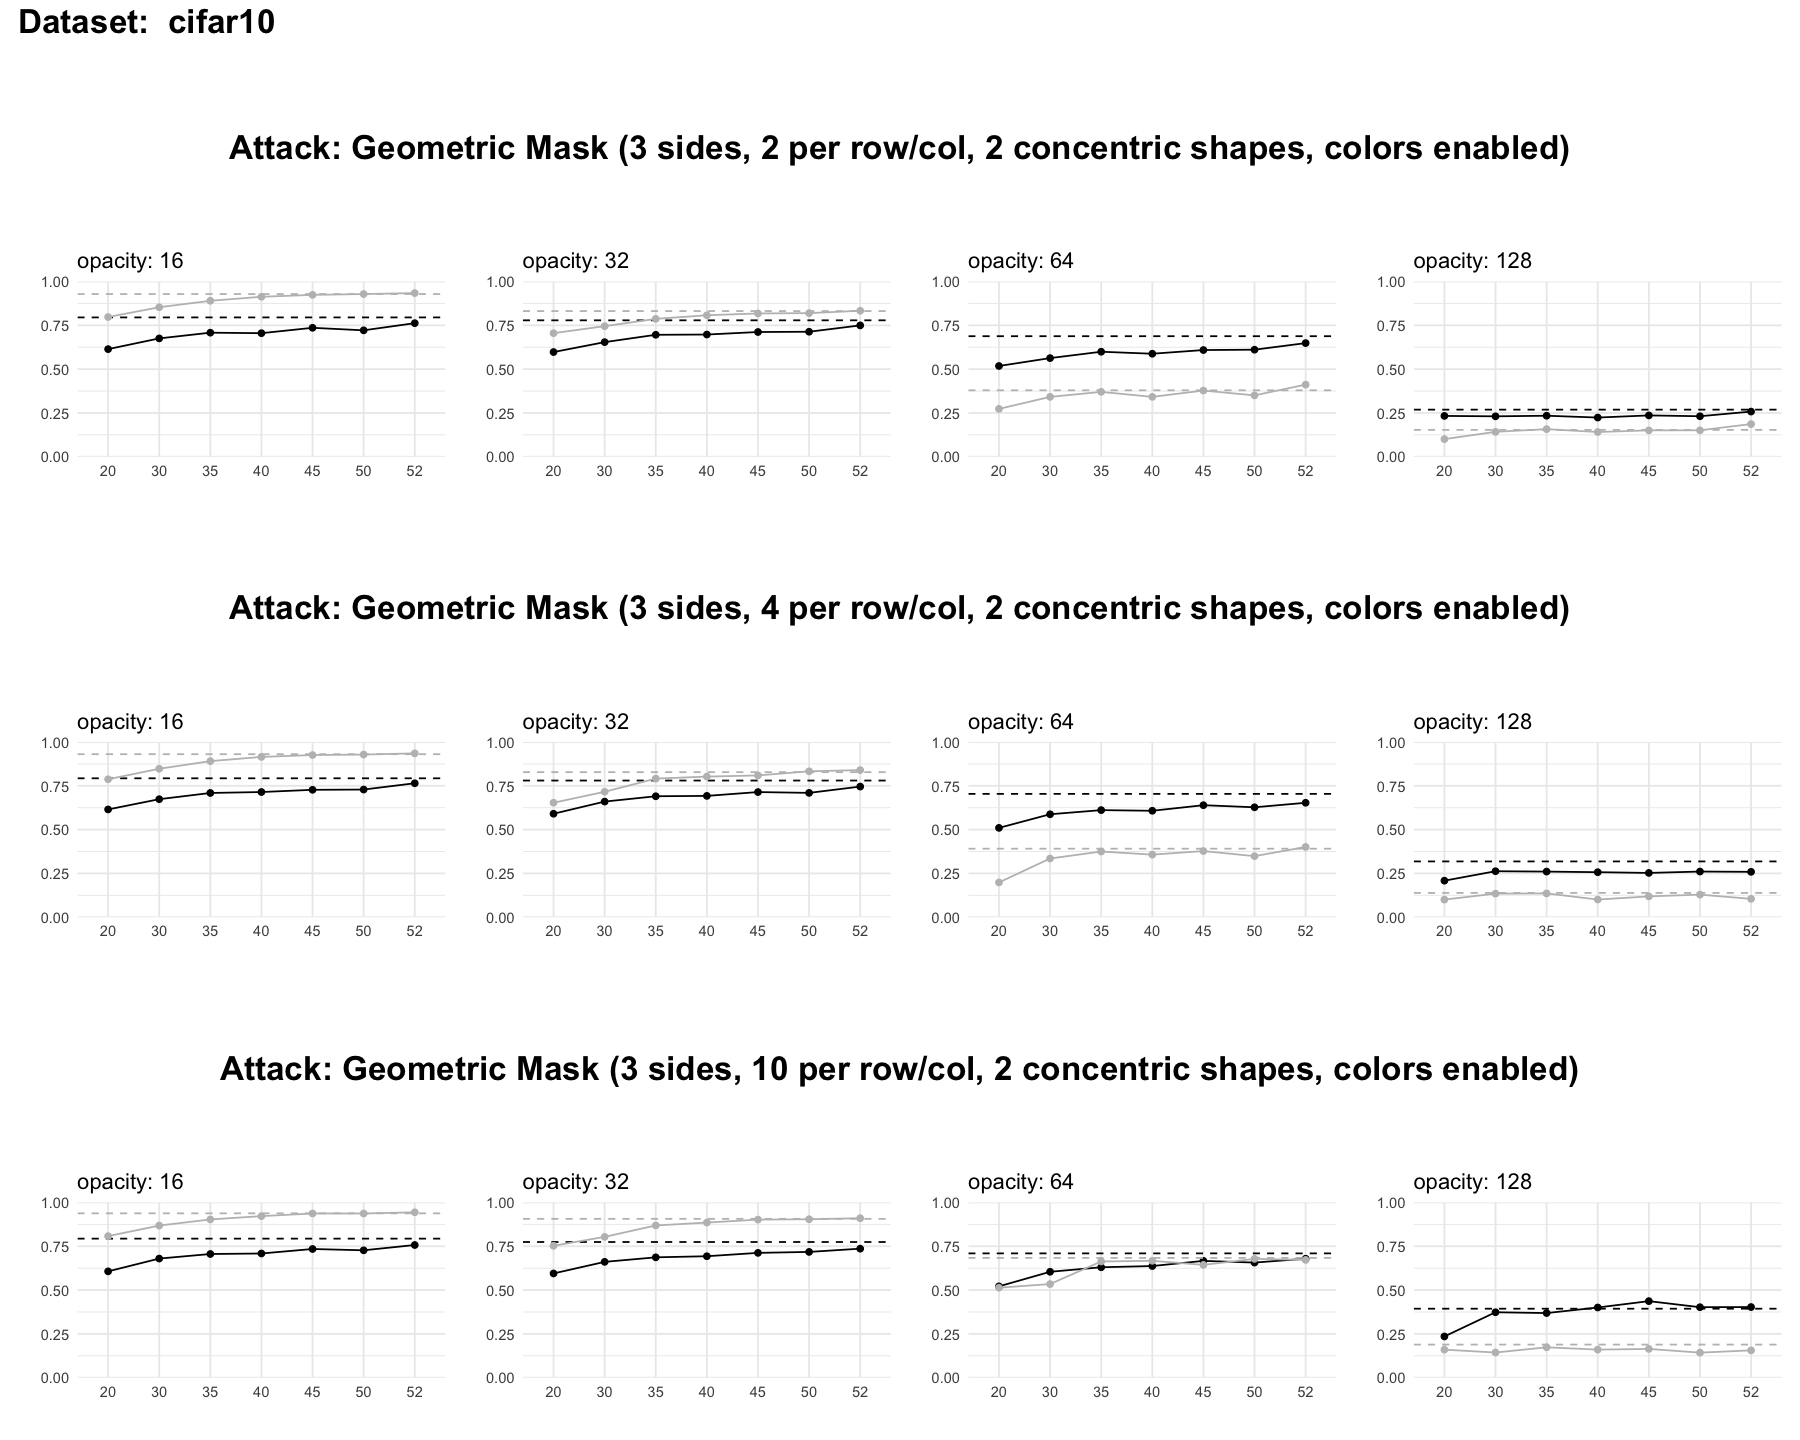

In [59]:
# taking a closer look at individual layers based on findings above

options(repr.plot.width=15, repr.plot.height=12)

# mask_opacities <- c(0, 1, 2, 4, 8, 16, 32, 64, 128)
# mask_sides <- c(3, 4, 6, 10)
# mask_per_rowcols <- c(2, 4, 10)
# mask_num_concentrics <- c(2, 5, 10)
# mask_colors <- c(TRUE, FALSE)

mask_sides <- c(3) # small difference
mask_per_rowcols <- c(2, 4, 10) # huge difference
mask_num_concentrics <- c(2) # no difference
mask_colors <- c(TRUE) # huge difference

combined_plots <- list()

combinations <- expand.grid(mask_sides, mask_per_rowcols, mask_num_concentrics, mask_colors)
for (i in 1:nrow(combinations)) {
    mask_opacities <- c(16, 32, 64, 128)
    
    title <- textGrob(paste("Attack: Geometric Mask (", combinations[i, 1], " sides, ", combinations[i, 2], " per row/col, ", combinations[i, 3], " concentric shapes, colors ", ifelse(combinations[i, 4], "enabled", "disabled"), ")", sep=""), gp = gpar(fontsize = 20, fontface = "bold"))

    plots <- list()
    for (mask_opacity in mask_opacities) {
        mask_side <- combinations[i, 1]
        mask_per_rowcol <- combinations[i, 2]
        mask_num_concentric <- combinations[i, 3]
        mask_color <- ifelse(combinations[i, 4], "True", "False")
        
        description <- paste("opacity:", mask_opacity, sep=" ")
        mask_name <- paste("mask", mask_opacity, mask_side, mask_per_rowcol, mask_num_concentric, mask_color, sep="_")

        acc_cols <- c(paste(mask_name, "_layer_accs.20", sep=""), paste(mask_name, "_layer_accs.30", sep=""), paste(mask_name, "_layer_accs.35", sep=""), paste(mask_name, "_layer_accs.40", sep=""), paste(mask_name, "_layer_accs.45", sep=""), paste(mask_name, "_layer_accs.50", sep=""), paste(mask_name, "_layer_accs.52", sep=""))
        acc_ensemble <- paste(mask_name, "_ensemble_acc", sep="")
        
        p <- get_plot(description, acc_cols, acc_ensemble)
        plots <- c(plots, list(p))
    }
    
    combined_plots[[length(combined_plots) + 1]] <- title
    combined_plots[[length(combined_plots) + 1]] <- patchwork::wrap_plots(plots, ncol = length(mask_opacities))
}

twidth <- 1
pwidth <- 5
p <- wrap_plots(
    ncol = 1,
    combined_plots,
    c(
        rep(c(twidth, rep(pwidth, length(mask_opacities))), length(combinations))
    )
)

ds <- unique(df$dataset)
p <- p + plot_annotation(
    title = paste("Dataset: ", ds),
    theme = theme(plot.title = element_text(size = 20, hjust = 0, face = "bold"))
)

print(p)
# ggsave("special_mask_attacks.pdf", p, width = 10, height = 12, units = "in")